# Setting up our Notebook

In [27]:
# Things to import

# Standard data, plotting, and mathematical tools
import numpy as np
import pandas as pd
import math as math
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# SARIMAX Modeling
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import acf
import pmdarima as pm
import statsmodels
import seaborn as sns

# For serialization:
import joblib
import pickle

# Warnings
import warnings
warnings.filterwarnings("ignore")

# SARIMAX Modeling on Price for BTC

## Importing and Visualization

In [7]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv']

In [16]:
# Reading in the data and creating our X and y matrices

X=pd.read_csv(dfs[0])
y=X['Close']

X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)
X=X.drop('Close', axis=1)

Text(0.5, 1.0, 'BTC Price')

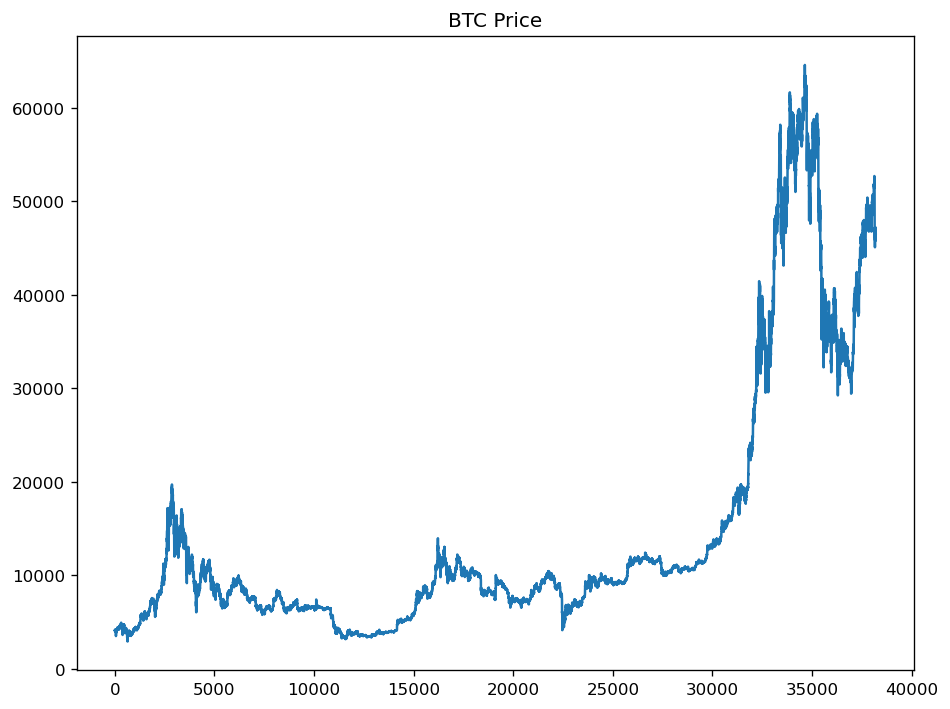

In [17]:
# Plotting our y

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
plt.plot(y)
plt.title('BTC Price')

Note: This section strongly follows the following guide https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ and https://towardsai.net/p/machine-learning/stock-price-change-forecasting-with-time-series-sarimax

## Manually setting up a model

### Parameters of the ARIMA model

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average.

### Differencing to Determine d

To begin, we need to determine whether or not to difference the data to make it more stationary. This will give us our parameter '"d".

We will use the Augmented Dickey Fuller Test to see if d should be anything other than 0, nothing that by looking at only the price change, we already have a difference of 1.

In [18]:
result = adfuller(y)
print('ADF Statistic for BTC Closing Values is '+str(result[0]))
print('p-value for BTC Closing Values is ' +str(result[1]))
print('\n')

ADF Statistic for BTC Closing Values is -0.1414947072405995
p-value for BTC Closing Values is 0.9451454287181401




We see that the data is not stationary. We will run the test again on differenced data.

In [19]:
# Single Differencing
result = adfuller(y.diff().dropna())
print('ADF Statistic for BTC Closing Values is '+str(result[0]))
print('p-value for BTC Closing Values is ' +str(result[1]))
print('\n')

ADF Statistic for BTC Closing Values is -28.290367410736565
p-value for BTC Closing Values is 0.0




So, we set d=1

### Auto-Correlation Plot to determine MA(q)

[]

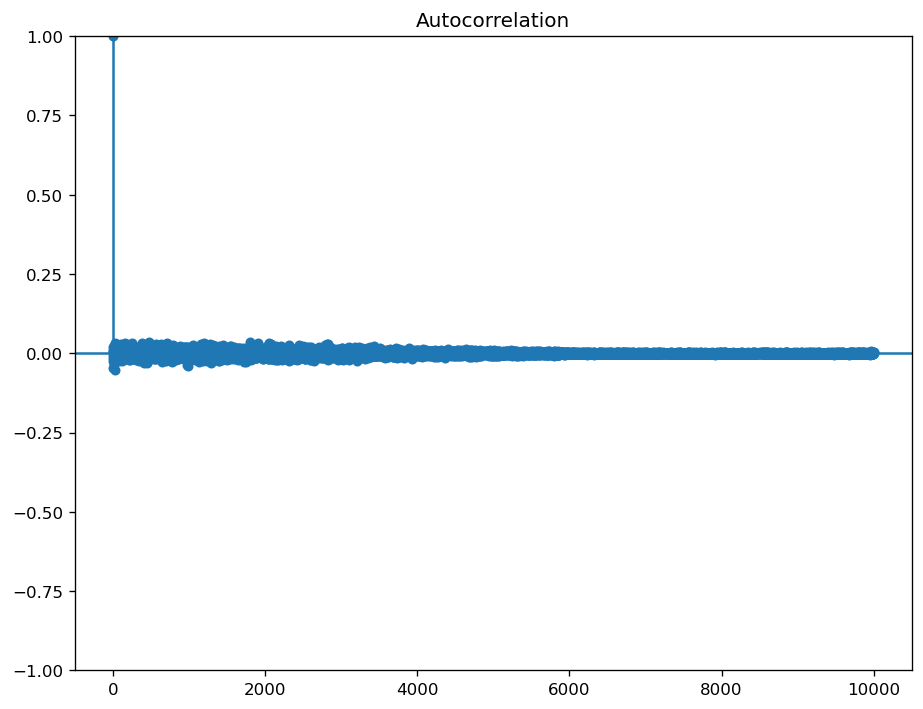

In [20]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

plot_acf(y.diff().dropna(), lags=10000)
plt.plot()

There seems to be a significant spike at q=4

### Partial Autocorrelation plot to determine AR(p)

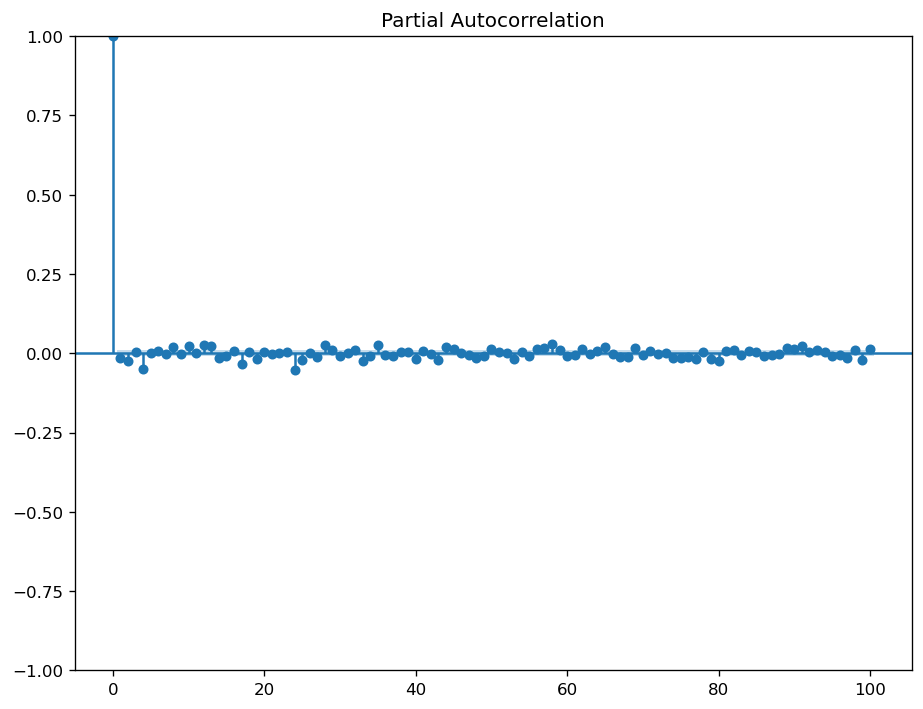

In [21]:
plot_pacf(y.diff().dropna(), lags=100)
plt.show()

There seems to be a significant spike at p=4

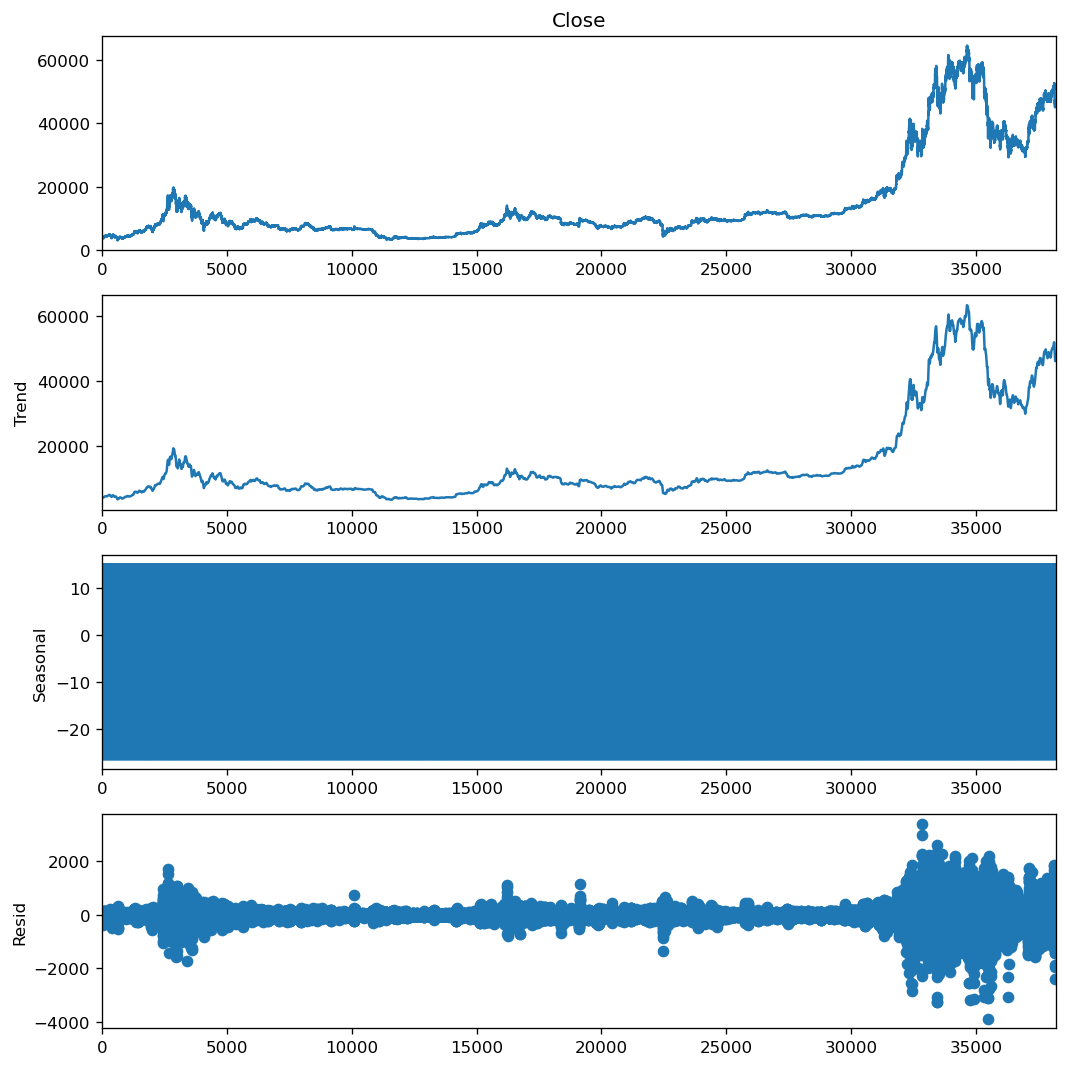

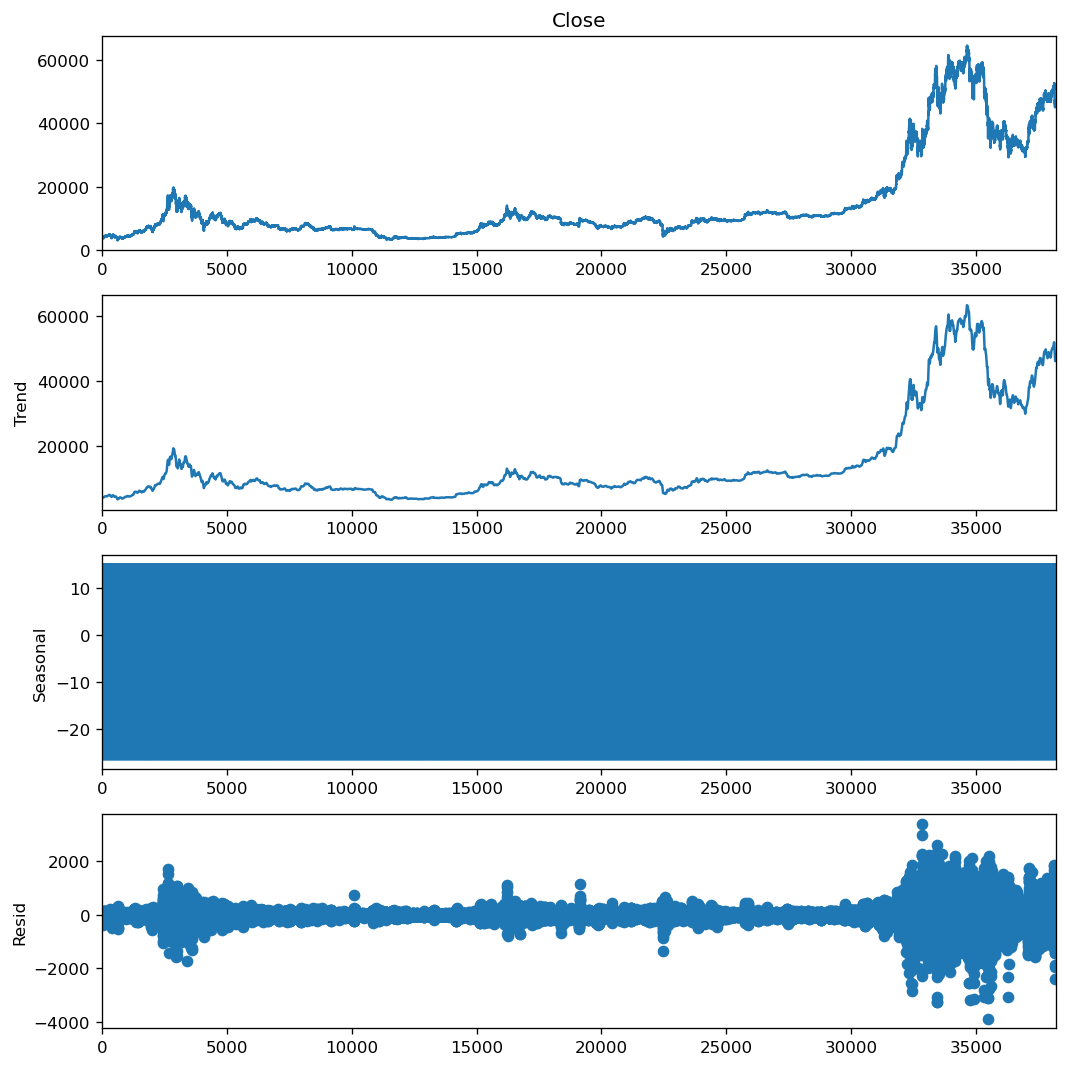

In [22]:
## from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Additive Decomposition
additive_decomposition = statsmodels.tsa.seasonal.seasonal_decompose(y, model='additive', period=30)

additive_decomposition.plot()
plt.tight_layout(rect=[0, 2, 1, 5])

# Multiplicative Decomposition
multiplicative_decomposition = statsmodels.tsa.seasonal.seasonal_decompose(y, model='multiplicative', period=30)

additive_decomposition.plot()
plt.tight_layout(rect=[0, 2, 1, 5])

plt.show()

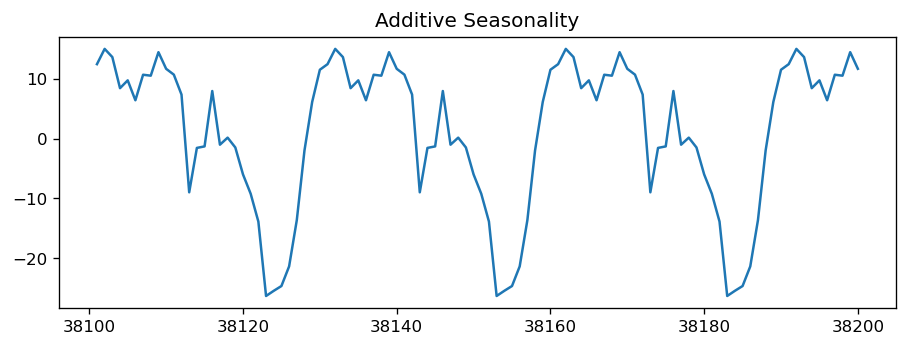

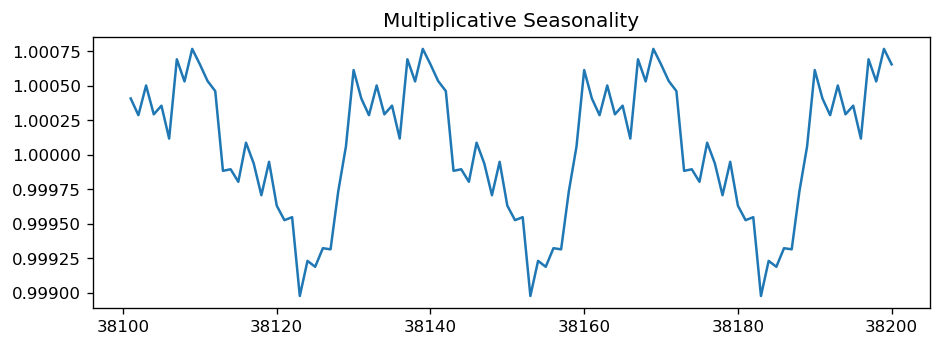

In [23]:
# plt.plot(additive_decomposition.seasonal[0:100])
add_season=additive_decomposition.seasonal[-100:]
plt.plot(add_season)
plt.title('Additive Seasonality')
plt.show()

mult_season=multiplicative_decomposition.seasonal[-100:]
plt.plot(mult_season)
plt.title('Multiplicative Seasonality')
plt.show()

Though it is hard to see in the original plot, on a shorter scale, we can find seasonaility in the 24 time-frame period.

## Auto-SARIMAX

### Data Preparation

In [24]:
# Defining a function to create PCA matrices

def PCA_creation_train_test(no_components, X_train, X_test):
    
    # Scaling the data with our X_train matrix
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    
    # Fitting the PCA to our X_train matrix
    pca=PCA(n_components=no_components)
    X_train=pca.fit_transform(X_train)

    # Scaling the X_test 
    X_test=scaler.transform(X_test)

    # Transforming the X_test
    X_test=pca.transform(X_test)
    
    return X_train, X_test

In [28]:
# split into train and test
X_train, X_val, y_train, y_val = train_test_split(X, y ,test_size=0.1, random_state=100, shuffle=False)


X_train, X_test=PCA_creation_train_test(20, X_train, X_val)

### Auto-SARIMAX

In [ ]:
from pmdarima.arima import auto_arima

auto_model = auto_arima(y_train.to_numpy(), exogenous=X_train.to_numpy(),
                        m=24, seasonal=True, suppress_warnings = True,  step_wise=False, trace=True)           
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=313364.421, Time=364.12 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=315341.871, Time=3.50 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=315075.558, Time=288.10 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=314837.559, Time=298.57 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=315340.208, Time=47.20 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=313364.570, Time=366.99 sec


Best model from SARIMAX:  ARIMA(0,1,1)(2,0,0)[2]  

However, empirically, we find that the best model is ARIMA(0,0,0)(2,0,2)[2]  

### SARIMAX with the best parameters identified by Auto-SARIMAX

#### Training

We will begin with a SARIMAX(0,0,1)(0,1,1)[24] model and see how it does, then compare it to a SARIMAX(0,0,1)(0,1,1)[24] model.

In [156]:
model = SARIMAX(endog=y_train.to_numpy(), exog=X_train.to_numpy().astype(float), 
                order=(0, 0, 1),seasonal_order=(0, 1, 1, 24))
model = model.fit(disp=False)
model.summary()

KeyboardInterrupt: 

#### Diagnostics

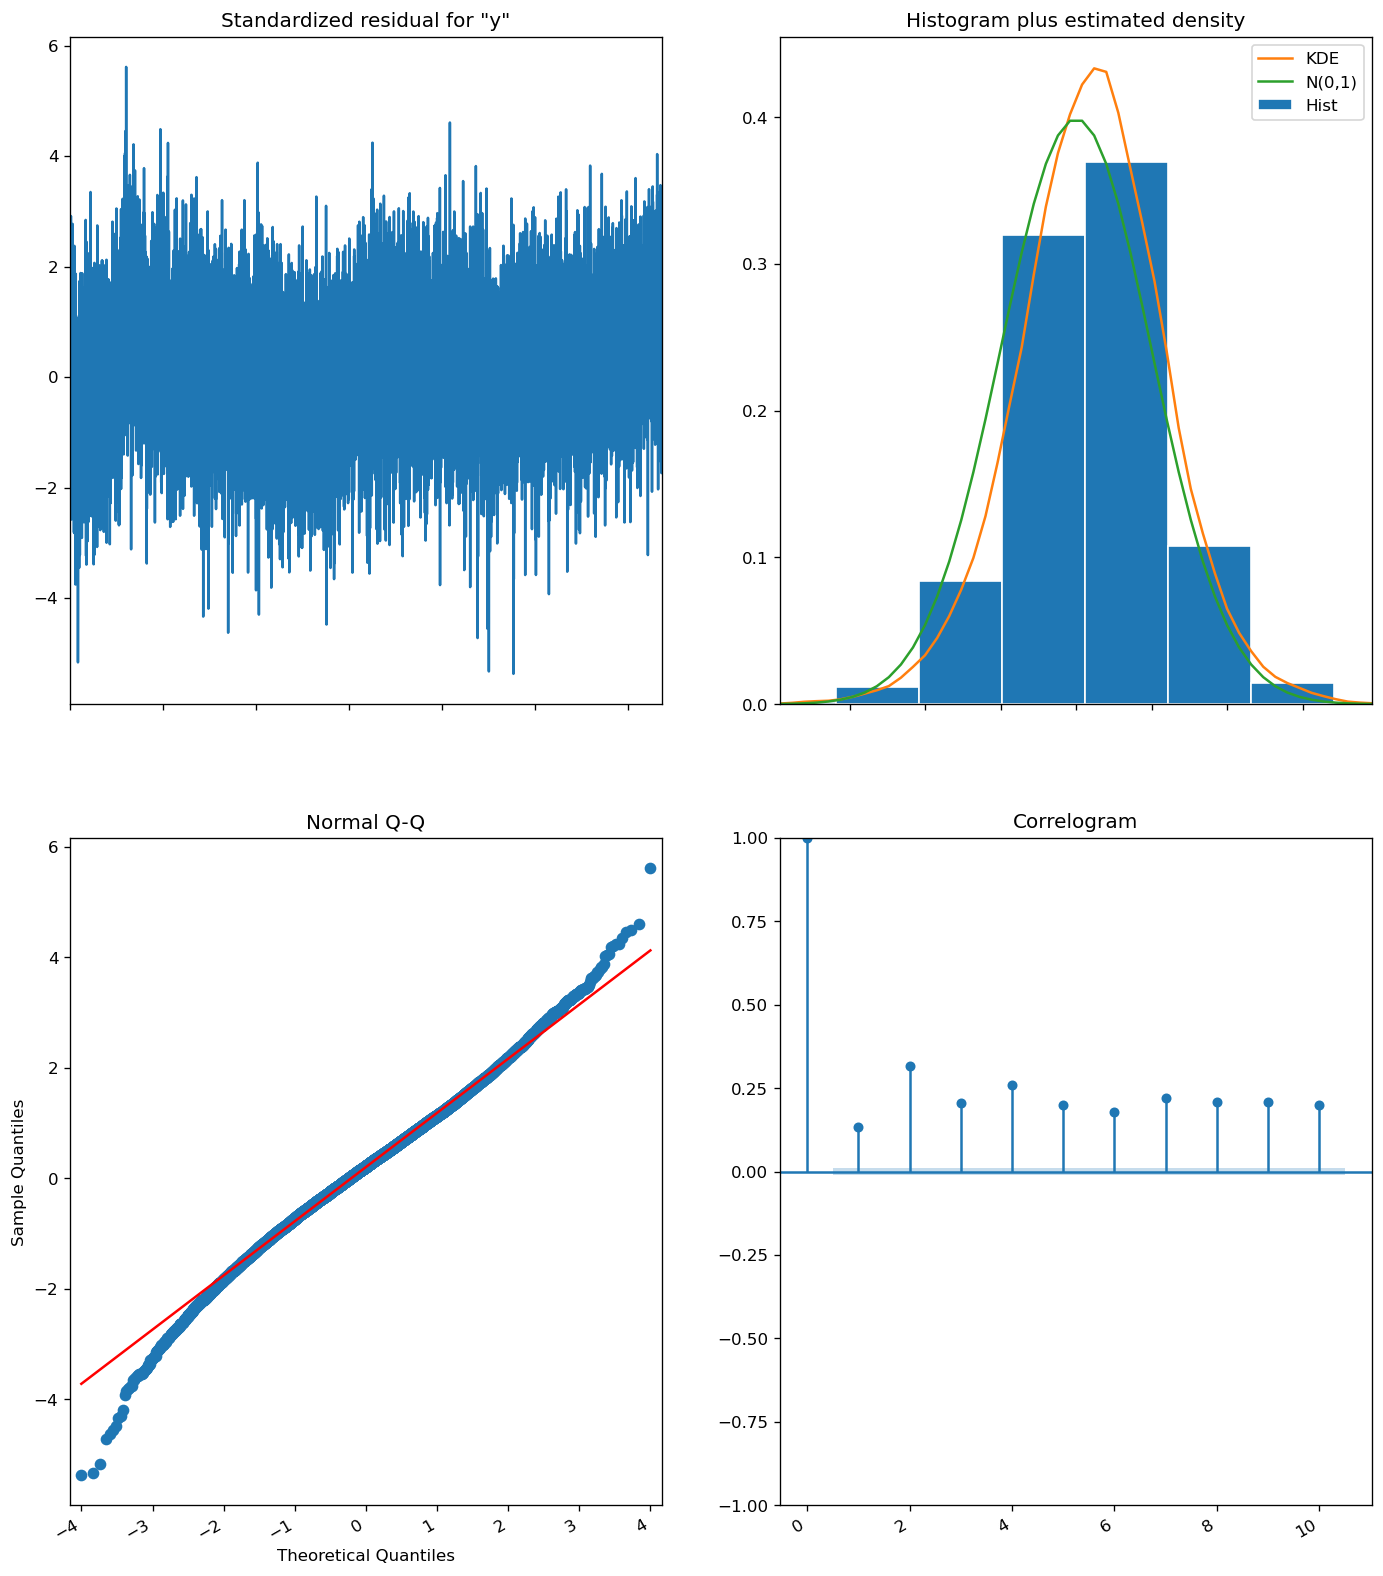

In [122]:
model.plot_diagnostics(figsize=(14,18))
plt.gcf().autofmt_xdate()
plt.show()

### Out-Of-Sample Forecasting

In [179]:
result = model.predict(start=len(X)-len(X_test), end=len(X)-1, exog=X_test.to_numpy().astype(float))

<AxesSubplot:>

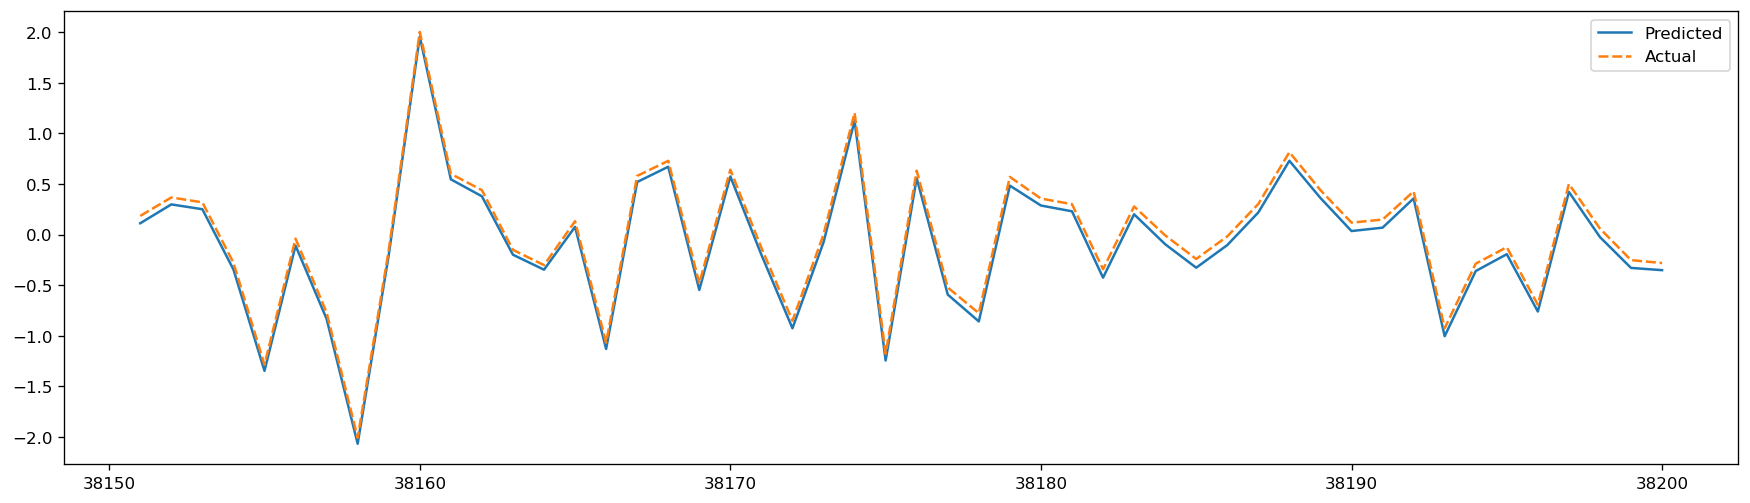

In [180]:
plt.figure(figsize=(18,5))
sns.lineplot(data=pd.DataFrame({'Predicted':result[-50:],'Actual':y_test[-50:]}))

### One-Step-Ahead Forecasting

In [ ]:
start_index = len(X)
end_index = len(X)
forecast = model.forecast(end_index, exog=X)
one_step_pred=forecast[-1]
print(one_step_pred)

### Saving and Reloading the Model

In [ ]:
# Save the model

model.save('Models/BTC 1H SARIMAX.pkl')

In [ ]:
# Reload the model

from statsmodels.tsa.statespace.sarimax import SARIMAXResults

# model=statsmodels.tsa.statespace.sarimax.SARIMAXResults.load('SARIMAX ETH.pkl')

model=SARIMAXResults.load('Models/BTC 1H SARIMAX.pkl')

# SARIMAX Modeling on Percent Change for BTC

## Importing the Data

In [29]:
# Reading in the data and creating our X and y matrices

X=pd.read_csv(dfs[0])
y=X['Percent Change']

X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)
X=X.drop('Close', axis=1)

Text(0.5, 1.0, 'BTC Percent Change')

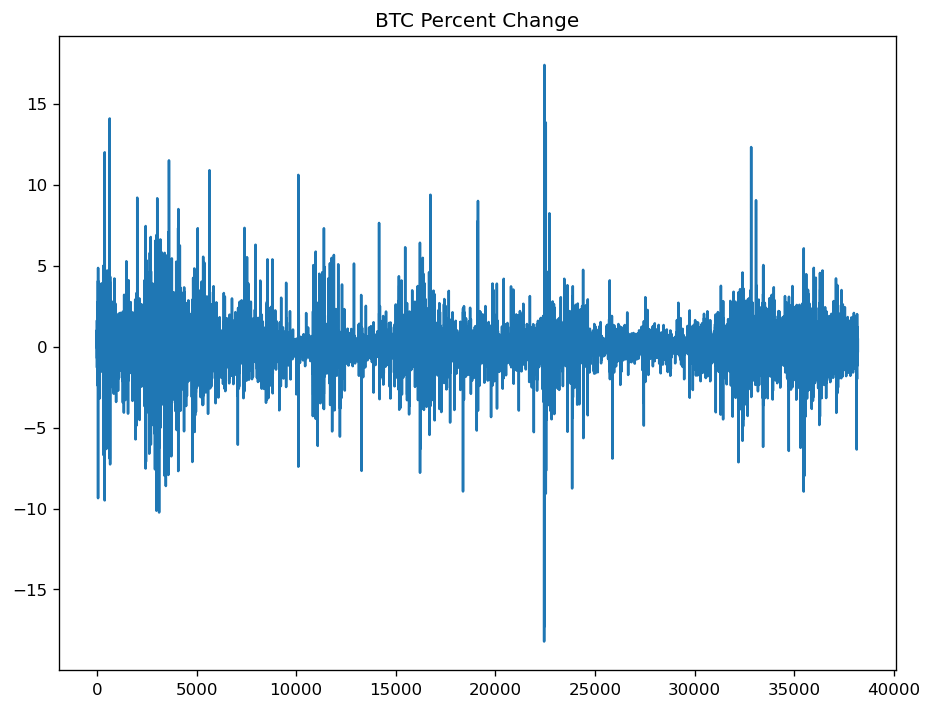

In [30]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
plt.plot(y)
plt.title('BTC Percent Change')

For SARIMAX modeling, we will not be attempting to classify something as a Buy/Hold/Sell signal, but to forecast the next time-step's change in price. From that, we can derive a trade signal using the same criteria used to create the categorical labels used in the other architectures.

Note: This section strongly follows the following guide https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ and https://towardsai.net/p/machine-learning/stock-price-change-forecasting-with-time-series-sarimax

## Manually setting up a model

### Parameters of the ARIMA model

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average.

### Differencing to Determine d

To begin, we need to determine whether or not to difference the data to make it more stationary. This will give us our parameter '"d".

We will use the Augmented Dickey Fuller Test to see if d should be anything other than 0, nothing that by looking at only the price change, we already have a difference of 1.

In [31]:
result = adfuller(y)
print('ADF Statistic is '+str(result[0]))
print('p-value for is ' +str(result[1]))
print('\n')

ADF Statistic is -27.765983580387037
p-value for is 0.0




We see that the data is stationary. So, we set d=0

### Auto-Correlation Plot to determine MA(q)

[]

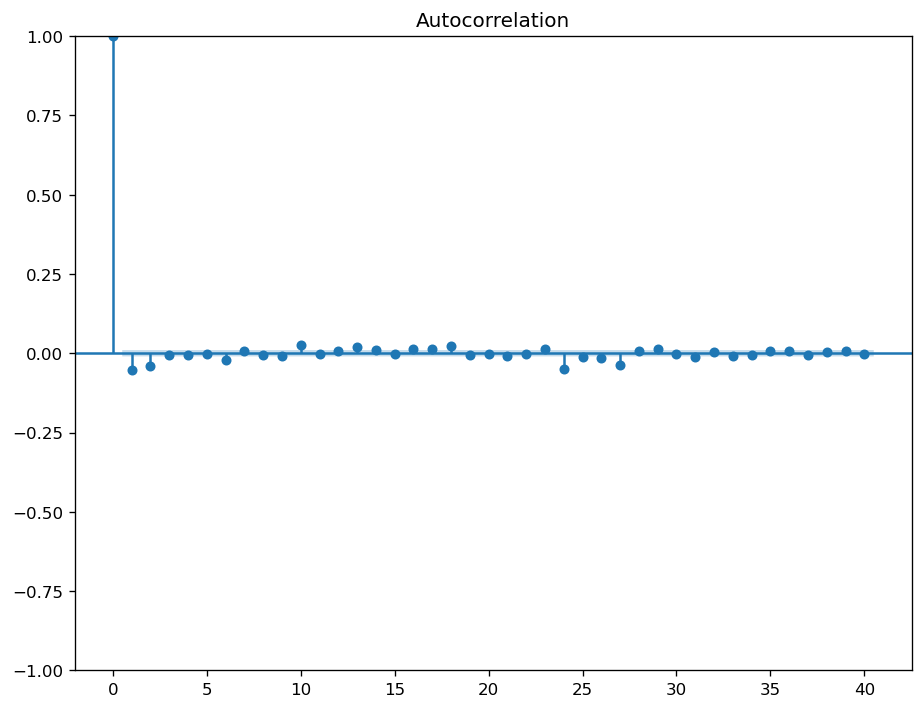

In [32]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

plot_acf(y.dropna(), lags=40)
plt.plot()

There seems to be a significant spike at q=1, and a possible seasonal spike at 24 time-periods

### Partial Autocorrelation plot to determine AR(p)

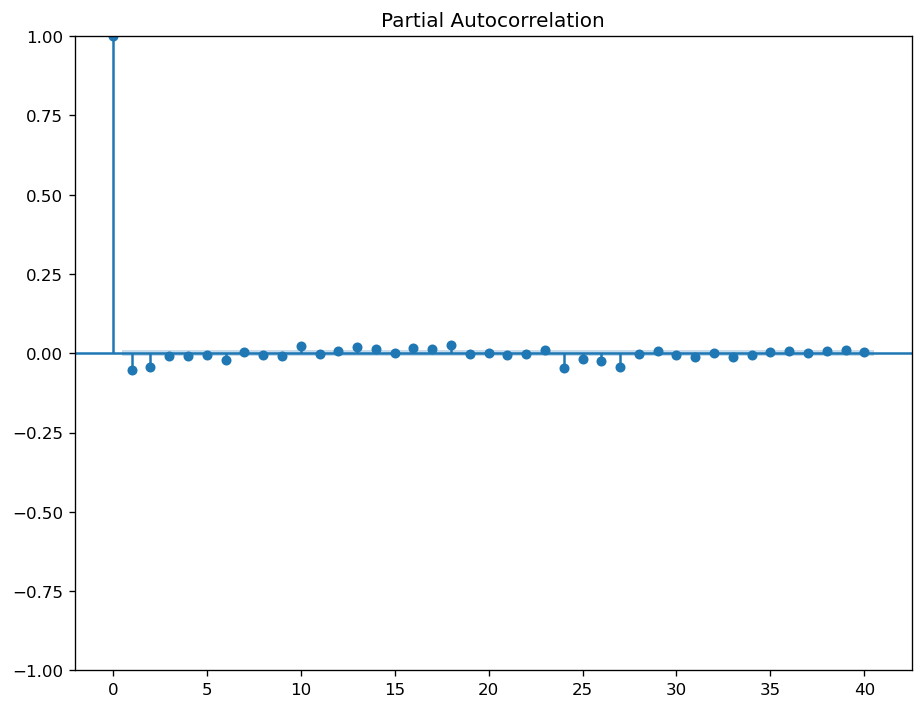

In [33]:
plot_pacf(y.dropna(), lags=40)
plt.show()

There seems to be a significant spike at q=1, and a possible seasonal spike at 24 time-periods

Our data has negative values, so Multiplicative Decomposition is not appropriate

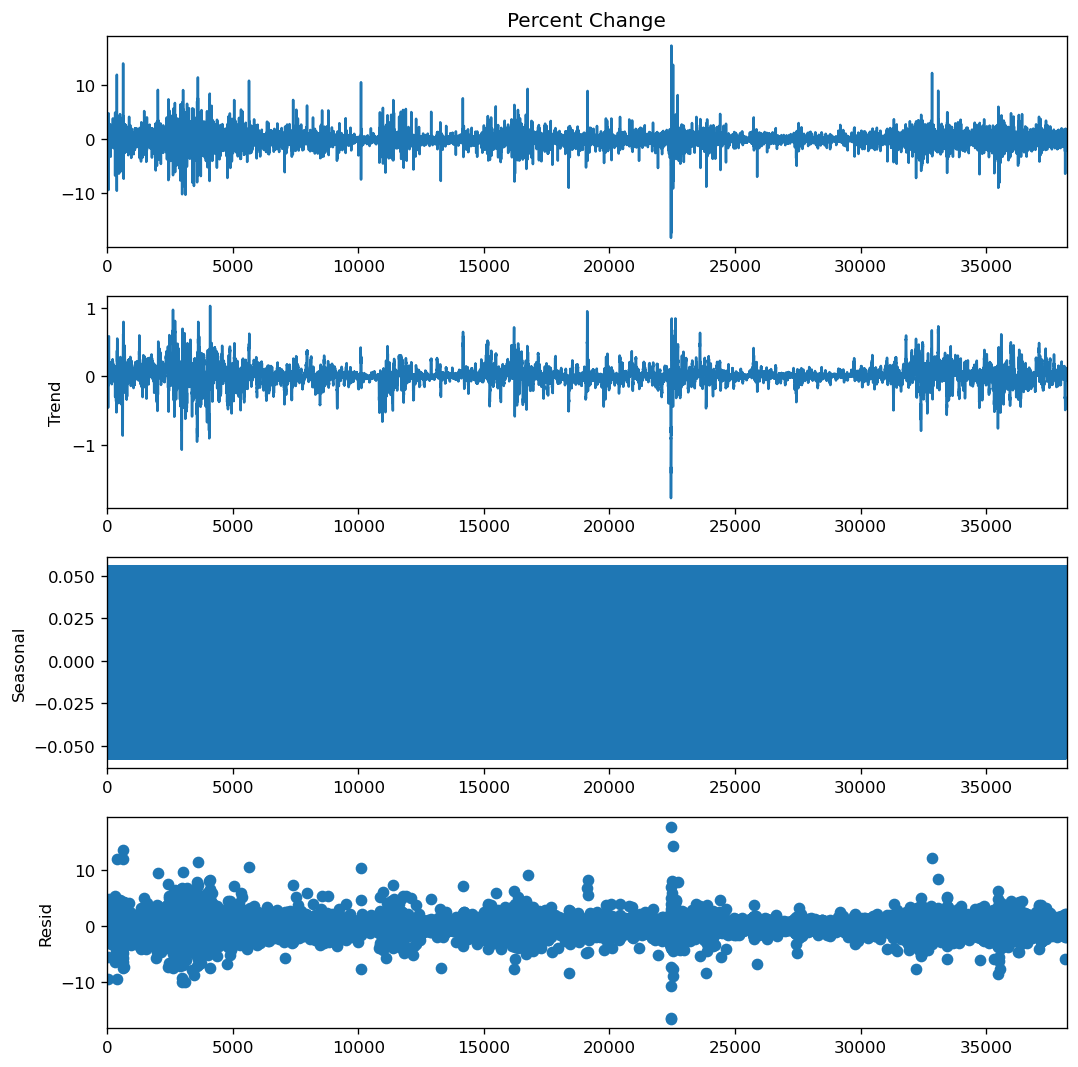

In [34]:
## from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Additive Decomposition
additive_decomposition = statsmodels.tsa.seasonal.seasonal_decompose(y, model='additive', period=30)

additive_decomposition.plot()
plt.tight_layout(rect=[0, 2, 1, 5])

plt.show()

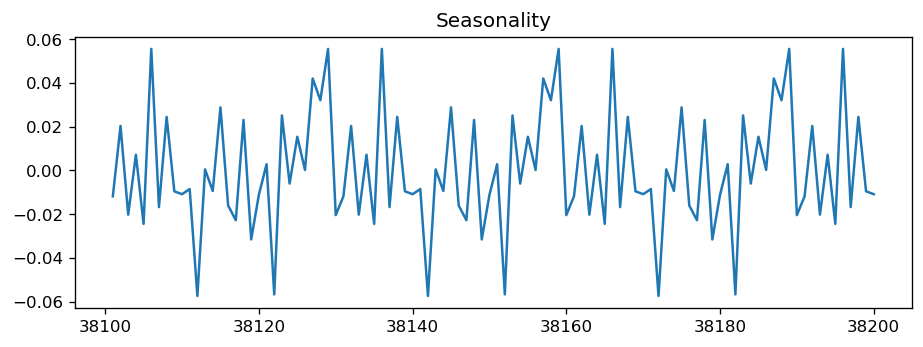

In [35]:
# plt.plot(additive_decomposition.seasonal[0:100])
add_season=additive_decomposition.seasonal[-100:]
plt.plot(add_season)
plt.title('Seasonality')
plt.show()

Though it is hard to see in the original plot, on a shorter scale, we can find seasonaility in the 24 time-frame period.

## Auto-SARIMAX

### Data Preparation

In [36]:
# split into train and test
X_train, X_val, y_train, y_val = train_test_split(X, y ,test_size=0.1, random_state=100, shuffle=False)


X_train, X_test=PCA_creation_train_test(20, X_train, X_val)

### Auto-SARIMAX

In [ ]:
# We must set the 'stationary' to True, as our data is already stationary and d=0
auto_model = auto_arima(y_train.to_numpy(), exogenous=X_train.to_numpy(),
                        m=24, seasonal=True, suppress_warnings = True,  step_wise=False, trace=True,
                       stationary=True)

auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=313364.421, Time=364.12 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=315341.871, Time=3.50 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=315075.558, Time=288.10 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=314837.559, Time=298.57 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=315340.208, Time=47.20 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=313364.570, Time=366.99 sec


Best model from SARIMAX:  ARIMA(0,1,1)(2,0,0)[2]  

However, empirically, we find that the best model is ARIMA(0,0,0)(2,0,2)[2]  

### SARIMAX with the best parameters identified by Auto-SARIMAX

#### Training

In [156]:
model = SARIMAX(endog=y_train.to_numpy(), exog=X_train.to_numpy().astype(float), 
                order=(0, 0, 1),seasonal_order=(0, 1, 1, 24))
model = model.fit(disp=False)
model.summary()

KeyboardInterrupt: 

#### Diagnostics

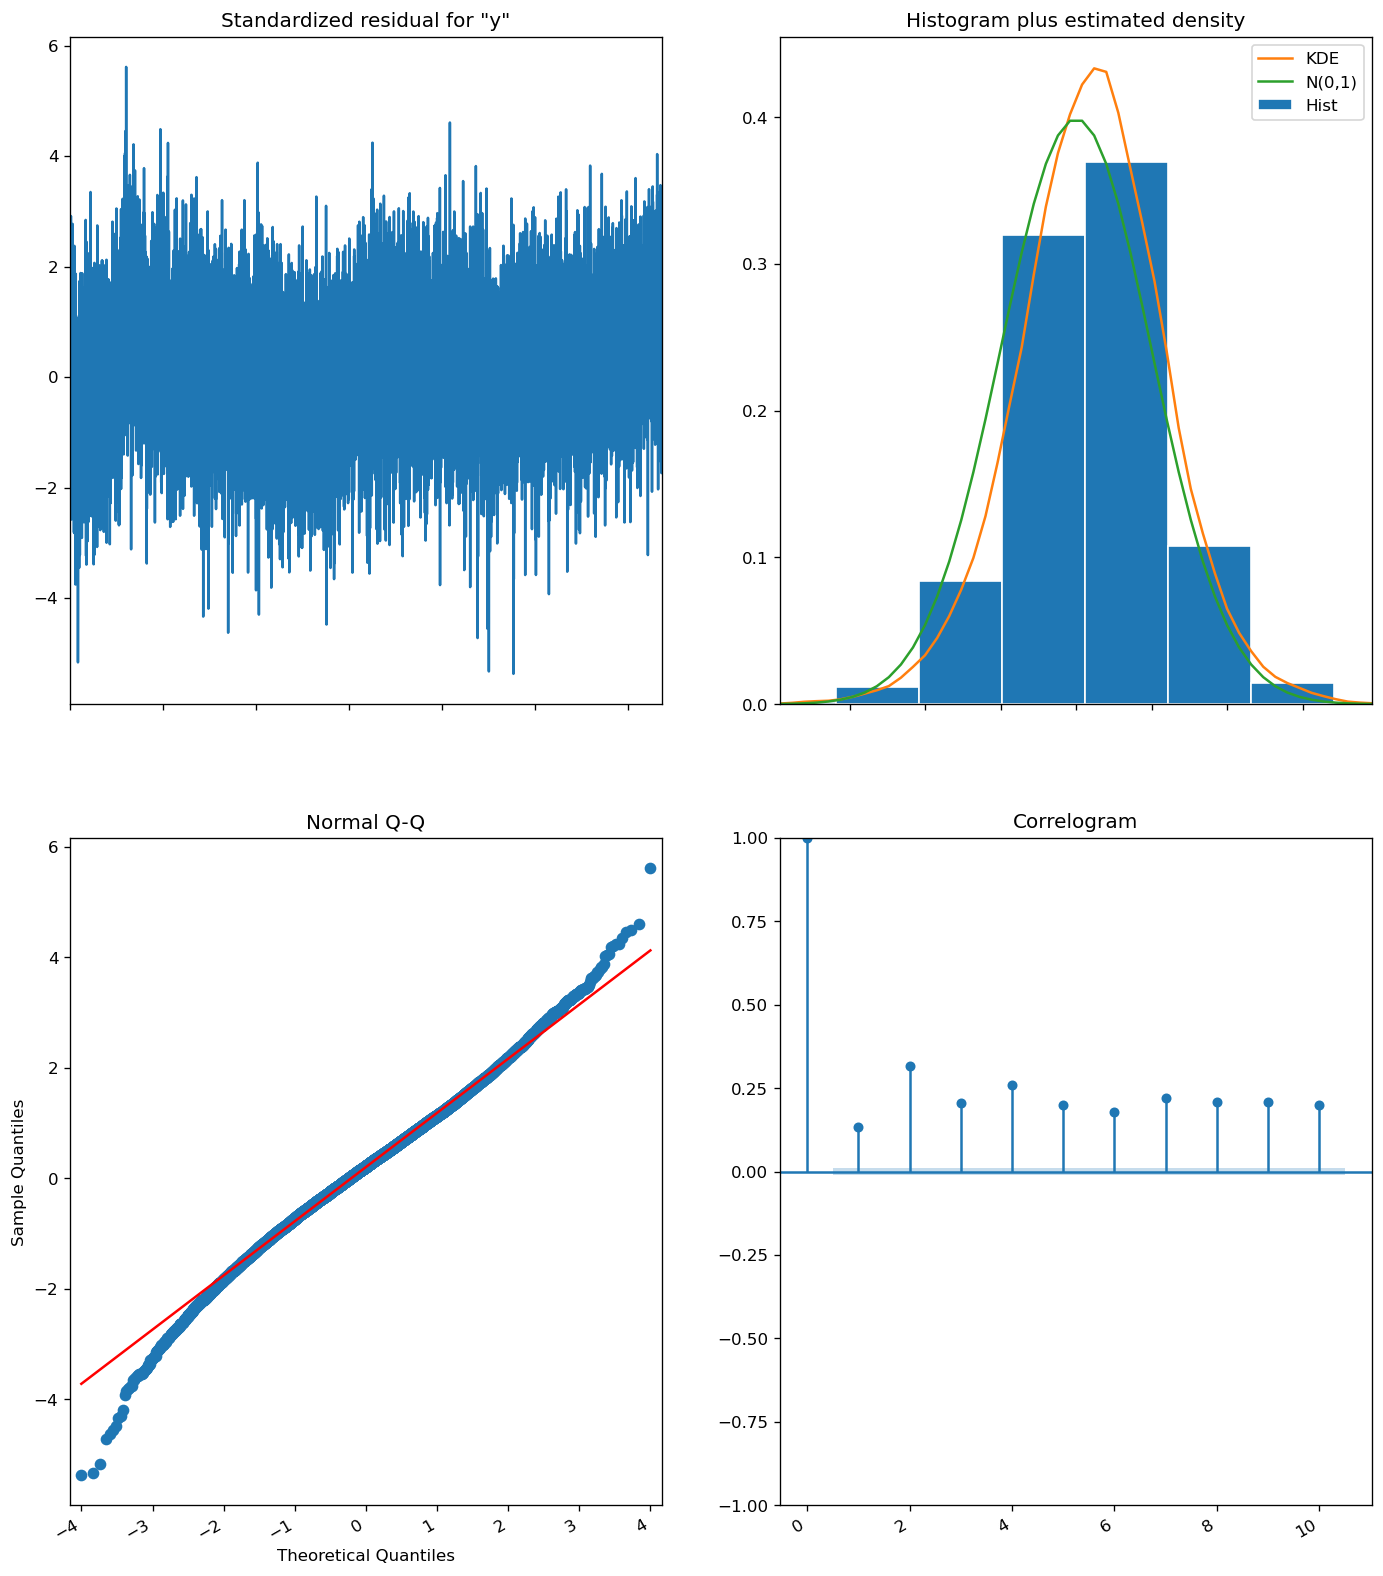

In [122]:
model.plot_diagnostics(figsize=(14,18))
plt.gcf().autofmt_xdate()
plt.show()

### Out-Of-Sample Forecasting

In [179]:
result = model.predict(start=len(X)-len(X_test), end=len(X)-1, exog=X_test.to_numpy().astype(float))

<AxesSubplot:>

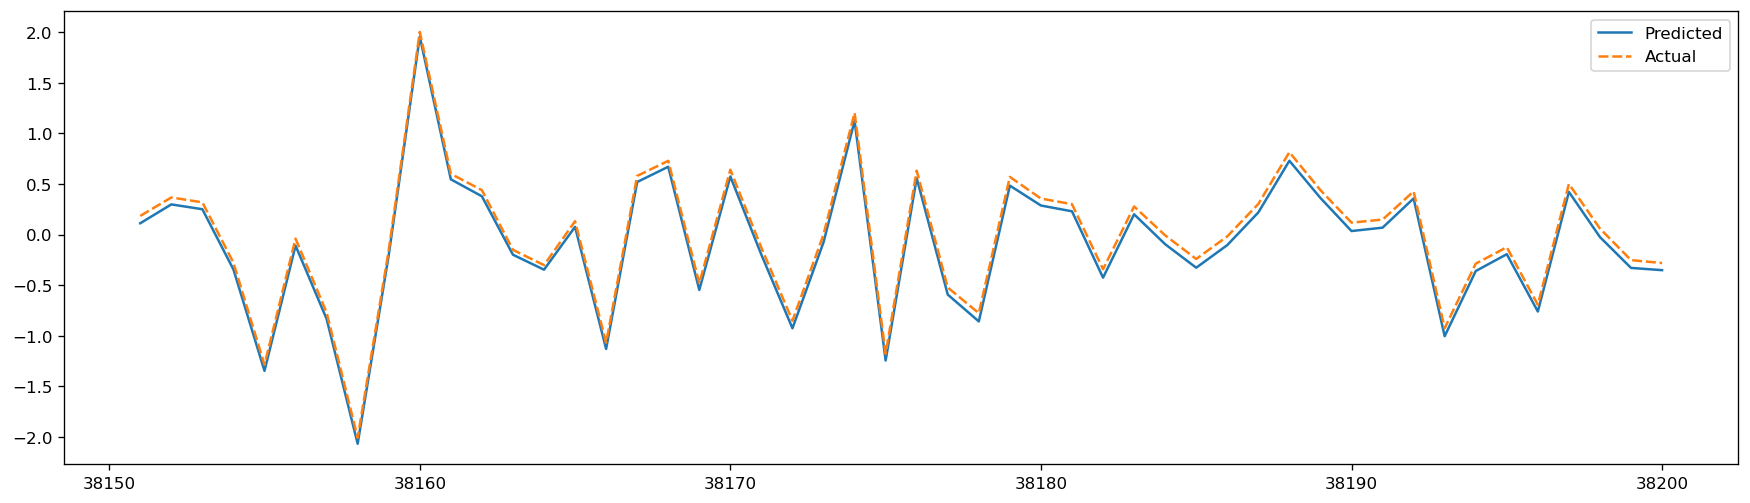

In [180]:
plt.figure(figsize=(18,5))
sns.lineplot(data=pd.DataFrame({'Predicted':result[-50:],'Actual':y_test[-50:]}))

### One-Step-Ahead Forecasting

In [ ]:
start_index = len(X)
end_index = len(X)
forecast = model.forecast(end_index, exog=X)
one_step_pred=forecast[-1]
print(one_step_pred)

### Saving and Reloading the Model

In [ ]:
# Save the model

model.save('Models/BTC 1H SARMAX.pkl')

In [ ]:
# Reload the model

model=SARIMAXResults.load('Models/BTC 1H SARMAX.pkl')